In [75]:
import csv
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from sklearn.linear_model import Lasso

import pysindy as ps
import pickle
import random
import pandas as pd

(31, 2)


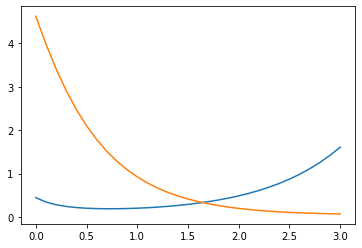

In [76]:
X = pd.read_csv('X.csv', sep=',',header=None)
# print(X.values)
X = np.array(X.values)
# print(X)
X = np.delete(X, 0, axis= 0)
X = np.array(X, dtype=np.float64)
# print(X)
for x in X:
    for y in range(len(x)):
        for z in range(len(X)):
            X[z][y] = float(X[z][y])
# print(X)
print(X.shape)
t_end = 3
tt = np.linspace(0, t_end, X.shape[0])
plt.plot(tt, X)

(31, 2)


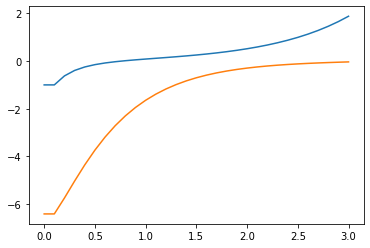

In [77]:
DX = pd.read_csv('DX.csv', sep=',',header=None)
DX = np.array(DX.values)
DX = np.delete(DX, 0, axis= 0)
DX = np.array(DX, dtype=np.float64)
for x in DX:
    for y in range(len(x)):
        for z in range(len(DX)):
            DX[z][y] = float(DX[z][y])
# print(DX)
print(DX.shape)
plt.plot(tt, DX)

In [78]:
library_functions = [
    lambda x : x,
    # lambda x : x**3,
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    # lambda x : np.tanh(x)
]
library_function_names = [
    lambda x : x,
    # lambda x : x + "^3",
    lambda x : 'sin(' + x + ')',
    lambda x : 'cos(' + x + ')',
    # lambda x : 'tanh(' + x + ')'

]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=2)
# feature_library = custom_library
optimizer = ps.SR3(threshold=0.2)

In [79]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
dt= t_end/(X.shape[0]-1)
model.fit(X, x_dot=DX, t=dt, multiple_trajectories=False)
model.print()

x' = 0.973 x
y' = -2.103 y + 1.561 x y
C:\Users\Julius\AppData\Local\Programs\Python\Python37\lib\site-packages\pysindy\optimizers\sr3.py:178: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  ConvergenceWarning,


In [80]:
t_test = np.linspace(0, 3, X.shape[0])
random.seed(12)
x0_test = [0.44249296,4.6280594]
x_test = X
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.302143


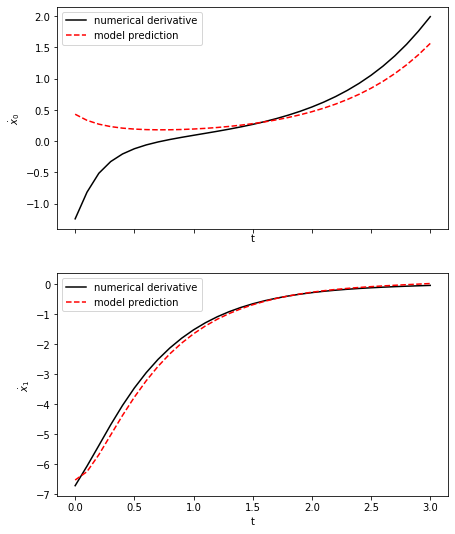

In [81]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)
#t_test = np.linspace(0, 15, 3000)


fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))

for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))

fig.show()

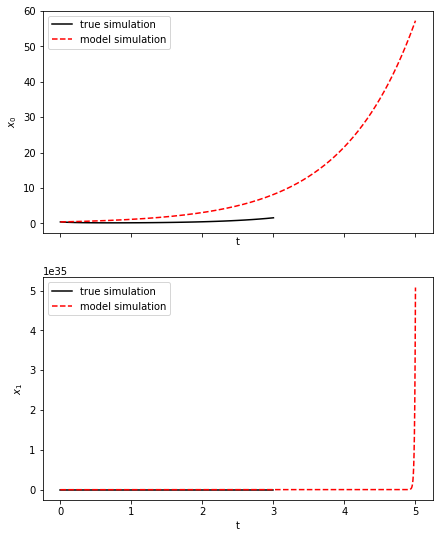

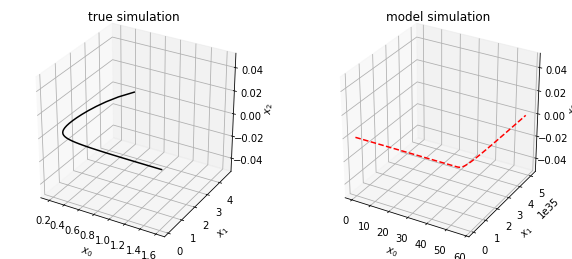

In [82]:
# Evolve the new initial condition in time with the SINDy model

t_evolve = np.linspace(0, 5, 1000)
x_test_sim = model.simulate(x0_test, t_evolve)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_evolve, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1],  'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()